In [14]:
# File written by adc2181
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
import spacy 
from spacy.tokenizer import Tokenizer
import numpy as np

nlp = spacy.load('en_core_web_sm')
tokenizer = Tokenizer(nlp.vocab)

# Read the dict
def learn_pronunciations(augmented=False):
    if augmented: # Include beginning/middle/end indicators
        lang = 'data/local/lang/align_lexicon.txt'
        sep = '\t'
    else: 
        lang = './data/local/dict/lexicon.txt'
        sep = ' '
    
    lang = open(lang, 'r').readlines()
    
    pronounce = {}
    for line in lang:
        line = line.strip().split(sep)
        pronounce[line[0]] = line[1:]
    return pronounce

def pronounce_text(text):
    tokens = tokenizer(text)
#     return [phone for token in tokens for phone in pronounce.get(token.text)]
    pron = []
    for token in tokens:
        pronunciation = pronounce.get(token.text)
        if pronunciation is None:
            return None
        for phone in pronunciation:
            pron.append(phone)
    return pron        

def read_phones():
    phones = './data/local/lang/phone_map.txt'
    phones = open(phones, 'r').readlines()
    
    phone2id, id2phone = {}, {}
    for i, phone in enumerate(phones):
        phone = phone.split(' ')
        phone2id[phone[0]] = i
        
    for phone, i in phone2id.items():
        id2phone[i] = phone
    
    return phone2id, id2phone
        
def phonehot(phone):
    onehot = np.zeros(p_N)
    onehot[phone2id[phone]] = 1
    return onehot

def unphonehot(onehot):
    for i in onehot:
        if i == 1:
            return id2phone[i]
        
def phone_vector(text):
    pronunciation = pronounce_text(text)
    if pronunciation is None:
        return None
    
    vec = np.zeros(p_N)
    for phone in pronunciation:        
        vec += phonehot(phone)
        
    return vec

def phone_vec2bag(vec):
    phone_bag = []
    for i in range(p_N):
        if vec[i]:
            for j in range(int(vec[i])):
                phone_bag.append(id2phone[i])
    return phone_bag

phone2id, id2phone = read_phones()
p_N = len(phone2id)
print('p_N', p_N)
pronounce = learn_pronunciations()
pronunciation = pronounce_text('this is a sentence')
print('pronounced', pronunciation)    
vec = phone_vector('this is a sentence')
print('vectorized bag', vec)
print('unvectorized bag', phone_vec2bag(vec))

p_N 41
pronounced ['DH', 'IH', 'S', 'IH', 'Z', 'AH', 'S', 'EH', 'N', 'T', 'AH', 'N', 'S']
vectorized bag [0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 2. 0. 0. 0. 0. 0. 3. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
unvectorized bag ['AH', 'AH', 'DH', 'EH', 'IH', 'IH', 'N', 'N', 'S', 'S', 'S', 'T', 'Z']


In [16]:
import numpy as np
import cv2
import os
import imghdr

class ImageNet():
    
    def __init__(self, batch_size):
        
        self.file_dir = './data/imagenet/scaled'
        self.batch_size = batch_size
        
        self.files = []
        for file in os.listdir(self.file_dir):
            if file != '.':
                file = os.path.join(self.file_dir, file)
                self.files.append(file)
                
        self.images = []
        self.labels = []
        
        self.unpronouncable = 0
        
        for filename in self.files:
            assert(imghdr.what(filename) == 'jpeg')
            
            image = cv2.imread(filename)
            img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            basename = os.path.basename(filename[1:].strip()).split('.')[0]
            vec = phone_vector(basename)
            
            if vec is None:
                self.unpronouncable += 1
            else:
                self.images.append(img_gray)
                self.labels.append(vec)
                # print(phone_vec2bag(vec))
            
        self.cur = 0
        self.N = len(self.images)
        
    def next_batch(self):
        batch = self.images[self.cur: self.cur + self.batch_size]
        batch_labels = self.labels[self.cur: self.cur + self.batch_size]
        self.cur += self.batch_size
        if self.cur > self.N: # Begin again
            self.cur = 0
        return np.array(batch), np.array(batch_labels)

print('Loading scaled ImageNet data')
imagenet = ImageNet(64)
print('N', imagenet.N)
print('unpronouncable', imagenet.unpronouncable)
batch, batch_label = imagenet.next_batch()
print('batch shape', batch.shape, batch_label.shape)

Loading scaled ImageNet data
N 3970
unpronouncable 2683
batch shape (64, 32, 32) (64, 41)


In [17]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32], name='X')
p_in = tf.placeholder(dtype=tf.float32, shape=[None, p_N], name='p_in')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 32 * 32])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2
print(inputs_decoder)

def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

24.5


In [18]:
def encoder(X_in, p_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 32, 32, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        
        p_in = tf.layers.dense(p_in, units=12, activation=lrelu)
        p = tf.layers.dense(p_in, units=n_latent, activation=lrelu)
        
        x = tf.concat([x, p], 1)
        
        mean = tf.layers.dense(x, units=n_latent)
        sd   = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mean + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mean, sd

In [19]:
def decoder(sampled_z, p_in, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
       
        p_in = tf.layers.dense(p_in, units=12, activation=lrelu)
        p = tf.layers.dense(p_in, units=n_latent, activation=lrelu)
        x = tf.concat([x, p], 1)
    
        x = tf.layers.dense(x, units=inputs_decoder * 2, activation=lrelu)
        
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=32*32, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 32, 32])
        return img

In [20]:
def discriminator(dec, keep_prob):
    with tf.variable_scope("discrim", reuse=None):
        activation = lrelu
        X = tf.reshape(dec, shape=[-1, 32, 32, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=32, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
    
        pred = tf.layers.dense(x, units=p_N)
        return pred

In [21]:
sampled, mean, sd = encoder(X_in, p_in, keep_prob)
dec = decoder(sampled, p_in, keep_prob)
pred = discriminator(dec, keep_prob)

In [22]:
unreshaped = tf.reshape(dec, [-1, 32*32])
img_loss = 0.00001 * tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
img_loss = tf.sqrt(img_loss)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mean) - tf.exp(2.0 * sd), 1)
latent_loss = tf.where(tf.is_nan(latent_loss), img_loss, latent_loss)
label_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=p_in, logits=pred))
loss = tf.reduce_mean(img_loss + label_loss + latent_loss)

optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

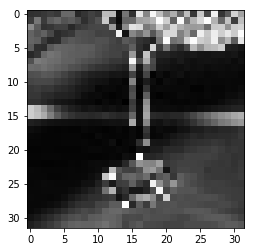

['AO', 'ER', 'T', 'W']


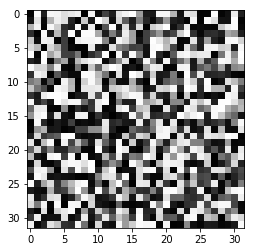

0 5.8933295e+16 14.515135 1706.9911 5.893329e+16


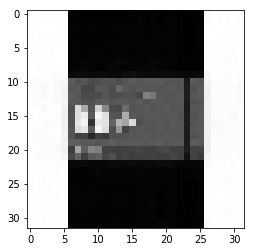

['AE', 'ER', 'L', 'N', 'P']


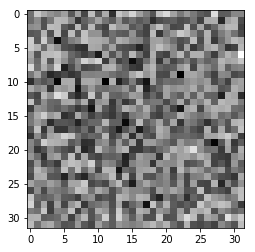

200 992.9844 13.81602 965.35236 13.81602


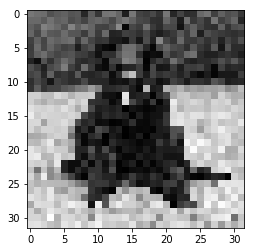

['AE', 'AH', 'D', 'D', 'D', 'ER', 'L', 'N', 'P', 'S', 'T', 'UW']


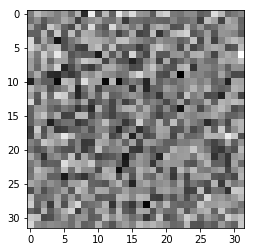

400 1025.8333 14.717219 996.39886 14.717219


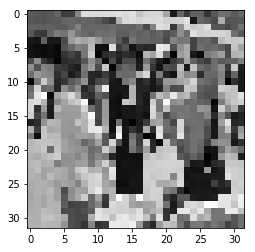

['IH', 'IY', 'L', 'M', 'OY', 'P']


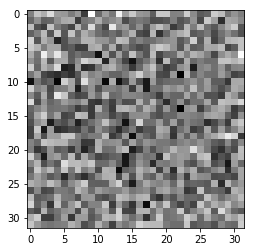

600 1034.6235 13.54287 1007.5379 13.54287


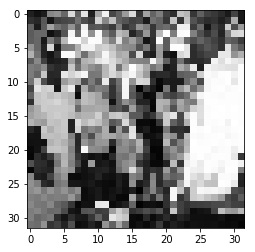

['EH', 'ER', 'HH', 'L', 'P']


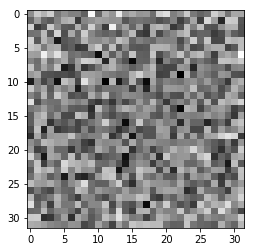

800 1039.5828 14.842707 1009.8974 14.842707


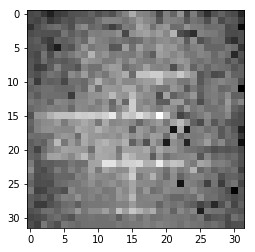

['B', 'IH', 'K', 'R']


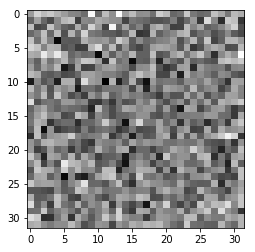

1000 1036.5833 15.196106 1006.19104 15.196106


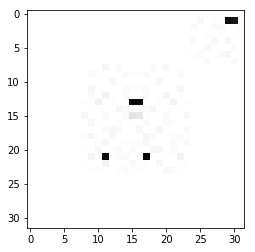

['EH', 'EY', 'F', 'M', 'R', 'R']


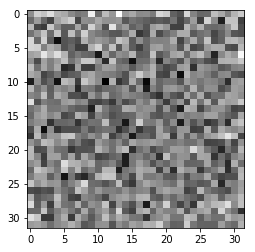

1200 1019.724 16.724924 986.2741 16.724924


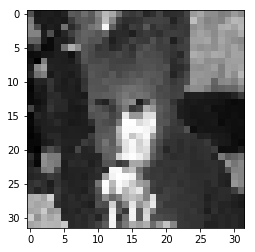

['AE', 'AH', 'D', 'ER', 'IH', 'L', 'P', 'T', 'Z']


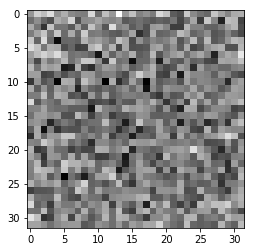

1400 1034.4888 15.451328 1003.5861 15.451328


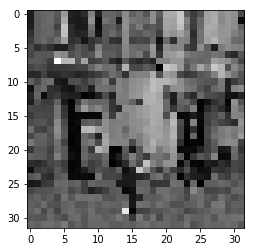

['AO', 'CH', 'EY', 'N', 'R', 'S', 'T']


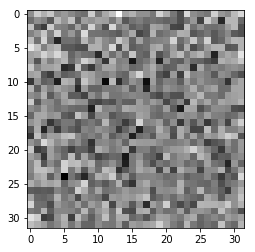

1600 1030.8657 15.686615 999.49243 15.686615


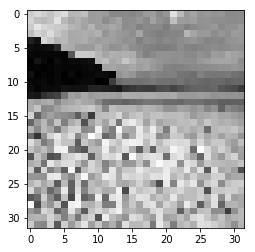

['P', 'R', 'S', 'UH']


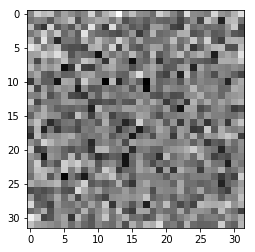

1800 1045.7169 14.633901 1016.4491 14.633901


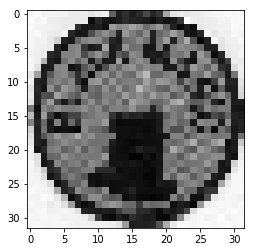

['AE', 'CH', 'D', 'ER', 'L', 'OW', 'P', 'SH']


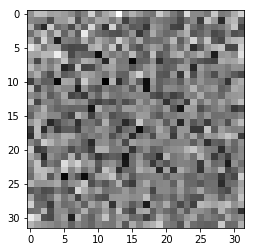

2000 1030.2483 15.342442 999.5633 15.342442


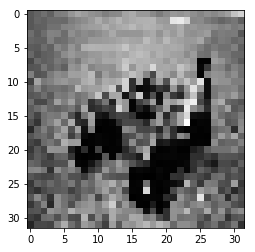

['AE', 'D', 'HH', 'IH', 'K', 'OW', 'R', 'S']


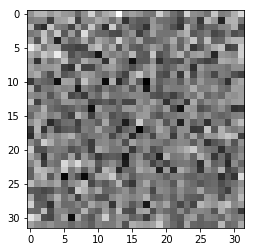

2200 1042.7603 14.092384 1014.57544 14.092384


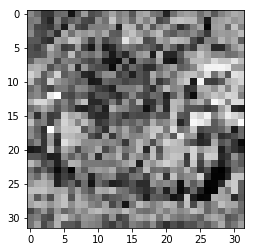

['AW', 'CH', 'IY', 'K', 'L', 'R', 'S']


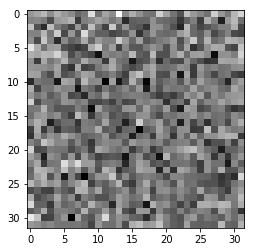

2400 1033.2186 14.831688 1003.55524 14.831688


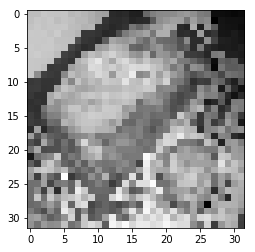

['F', 'L', 'OW']


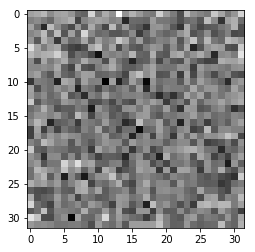

2600 1042.3114 13.059841 1016.19165 13.059841


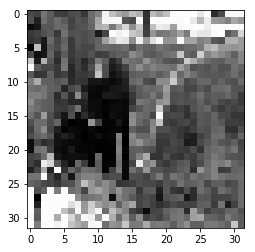

['EH', 'ER', 'F', 'HH']


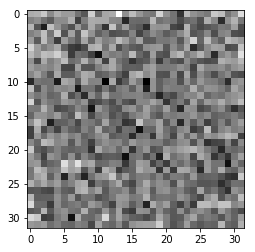

2800 1055.182 16.181568 1022.8189 16.181568


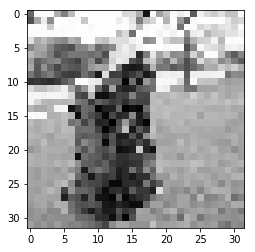

['AE', 'EH', 'ER', 'ER', 'IH', 'K', 'L', 'N', 'P', 'T', 'T', 'T']


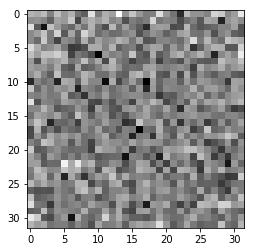

3000 1073.4292 16.629864 1040.1694 16.629864


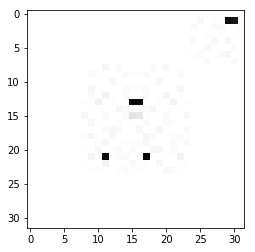

['AE', 'AH', 'AH', 'EY', 'JH', 'L', 'M', 'N', 'N', 'R']


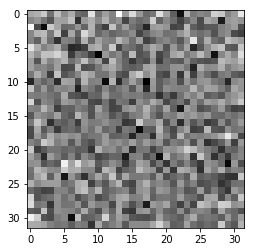

3200 1016.02246 14.136452 987.7495 14.136452


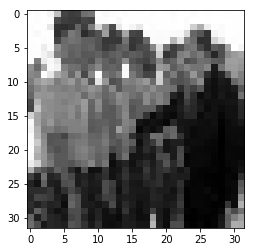

['AH', 'EY', 'IH', 'IH', 'JH', 'N', 'NG', 'P', 'SH', 'T']


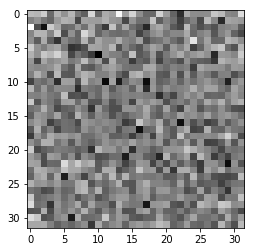

3400 1050.1078 14.348808 1021.41016 14.348808


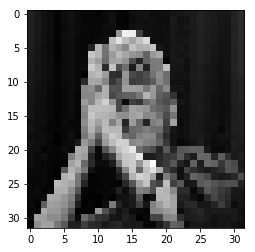

['AE', 'AH', 'AH', 'AO', 'DH', 'K', 'L', 'M', 'N', 'TH', 'V']


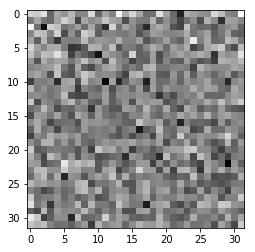

3600 1042.8435 14.836987 1013.1695 14.836987


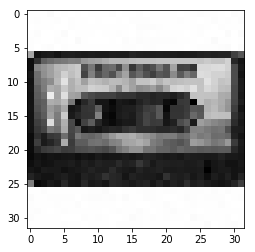

['AO', 'D', 'EY', 'IY', 'OW', 'P', 'T']


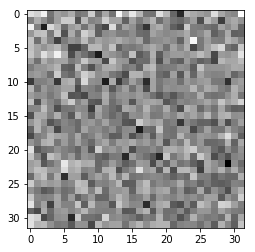

3800 1018.95056 14.841405 989.2677 14.841405


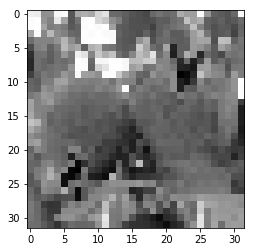

['F', 'IY', 'R', 'R', 'T', 'T', 'UW']


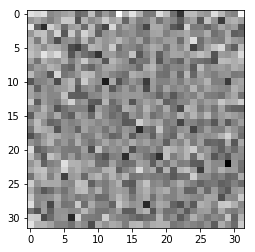

4000 1011.8903 14.702074 982.4862 14.702074


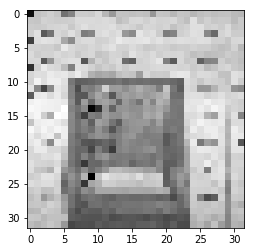

['AE', 'AO', 'B', 'K', 'L', 'NG', 'T', 'V']


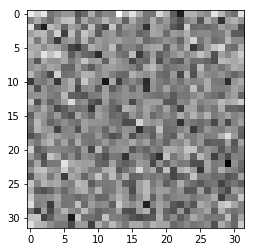

4200 1046.7751 15.387373 1016.0005 15.387373


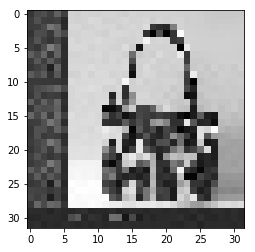

['ER', 'P', 'S']


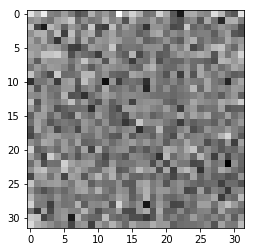

4400 1080.7965 14.153991 1052.4885 14.153991


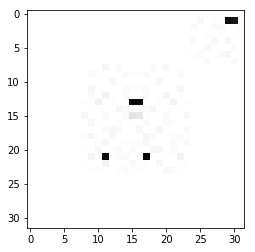

['EH', 'ER', 'IH', 'IY', 'K', 'L', 'S', 'S', 'T']


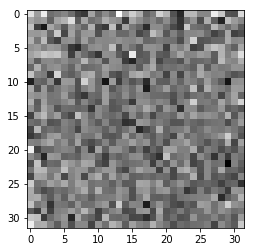

4600 1010.38965 15.269188 979.85126 15.269188


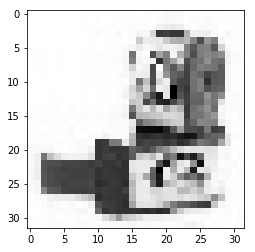

['AA', 'AH', 'B', 'IH', 'IH', 'IH', 'K', 'K', 'M', 'N', 'NG', 'P', 'S', 'T', 'W']


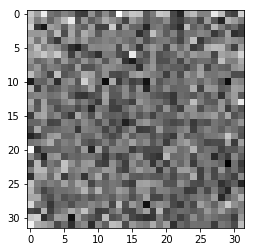

4800 1049.574 14.7527275 1020.0685 14.7527275


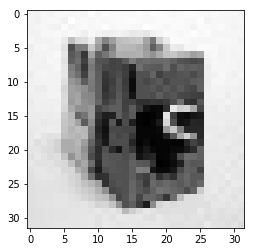

['AE', 'F', 'JH', 'K', 'N', 'OW']


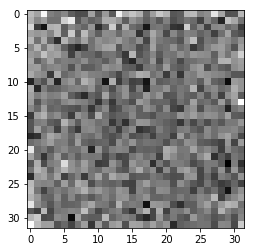

5000 1055.8408 15.800558 1024.2397 15.800558


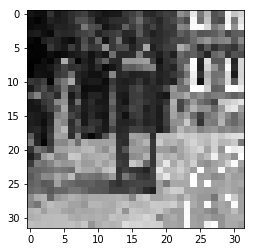

['AH', 'AO', 'EH', 'F', 'IY', 'K', 'K', 'L', 'N', 'OW', 'S', 'T']


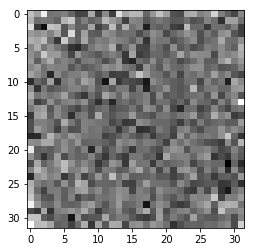

5200 1010.33606 14.019826 982.29645 14.019826


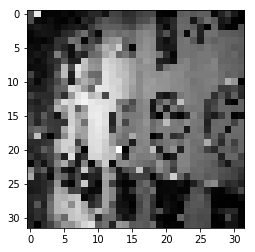

['EY', 'G', 'JH']


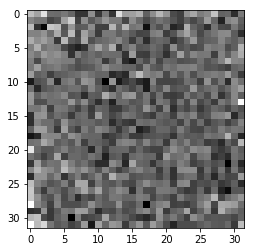

5400 1038.5988 14.688496 1009.2218 14.688496


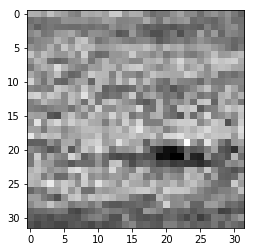

['D', 'IH', 'IY', 'L', 'R']


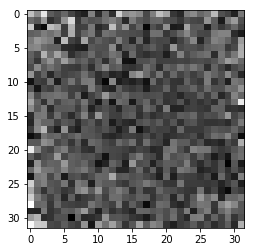

5600 1026.1777 15.139994 995.8978 15.139994


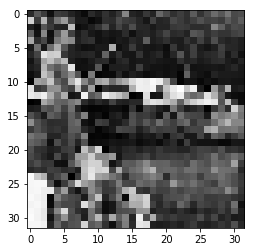

['AH', 'ER', 'N', 'P', 'T']


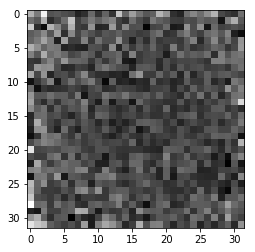

5800 1024.6989 14.531756 995.6353 14.531756


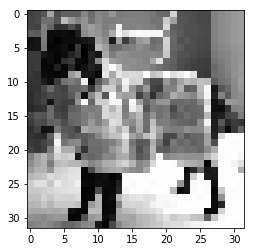

['AE', 'AW', 'B', 'L', 'T', 'TH']


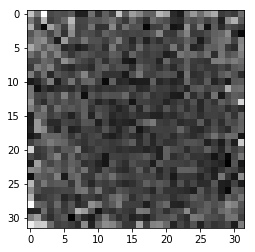

6000 1027.0219 15.491423 996.039 15.491423


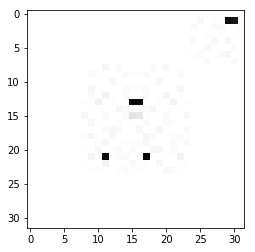

['AO', 'B', 'ER', 'JH']


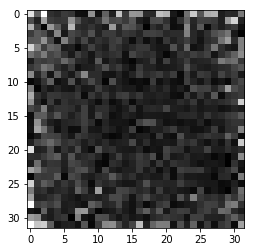

6200 1020.95984 16.281199 988.39746 16.281199


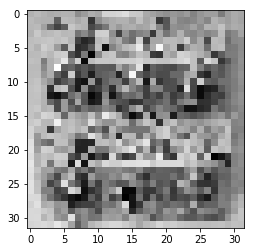

['AH', 'AO', 'CH', 'EH', 'G', 'K', 'L', 'T']


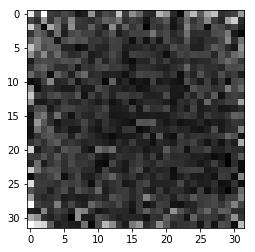

6400 1028.6206 13.843035 1000.93463 13.843035


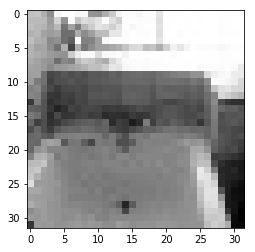

['AY', 'B', 'D', 'IH', 'T']


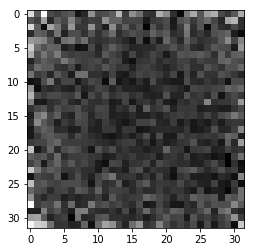

6600 1029.4104 14.983986 999.4425 14.983986


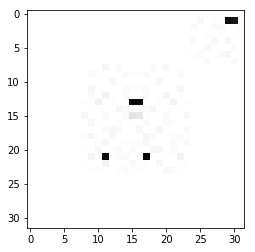

['AE', 'B', 'T']


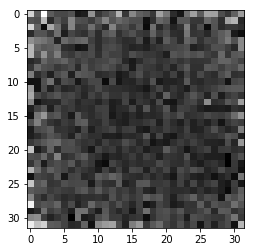

6800 1082.3812 15.045962 1052.2893 15.045962


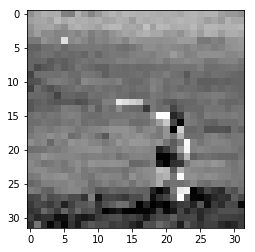

['AO', 'K', 'R', 'T']


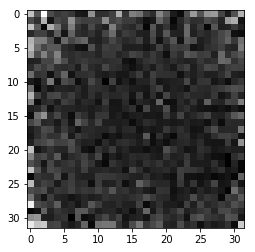

7000 1053.218 13.689303 1025.8395 13.689303


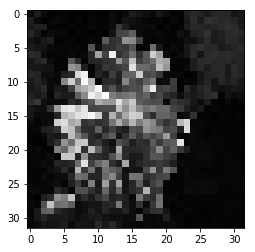

['AE', 'ER', 'S', 'T']


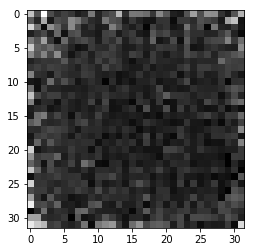

7200 1038.316 13.908407 1010.49927 13.908407


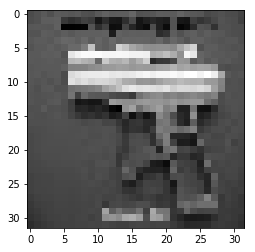

['AA', 'AH', 'B', 'EY', 'G', 'L', 'N', 'N', 'P', 'T']


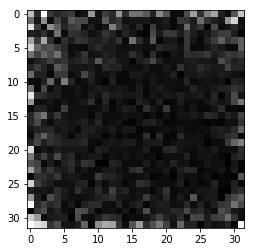

7400 1017.5372 14.326586 988.88403 14.326586


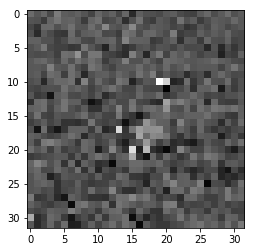

['AH', 'R', 'SH', 'TH']


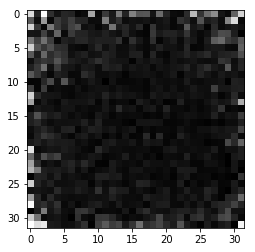

7600 1036.9473 14.838707 1007.2698 14.838707


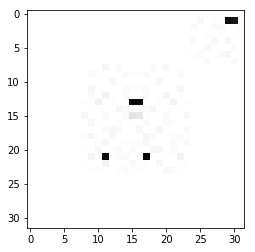

['AH', 'IH', 'JH', 'N', 'P']


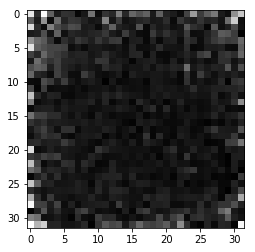

7800 1011.47577 14.838473 981.7988 14.838473


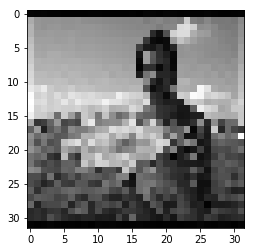

['AE', 'B', 'ER', 'L', 'M']


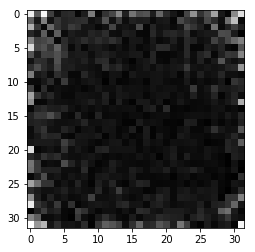

8000 60.348347 14.517147 31.314054 14.517147


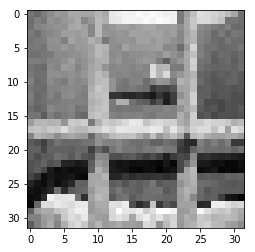

['AH', 'EH', 'IH', 'L', 'N', 'P', 'R', 'S', 'Z']


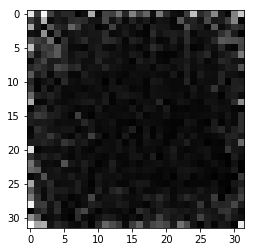

8200 1007.81964 15.5316515 976.75635 15.5316515


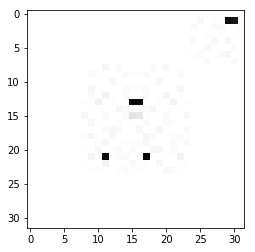

['B', 'IH', 'NG', 'OW', 'OW', 'R', 'T']


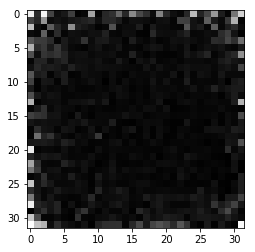

8400 1012.3941 15.557405 981.2793 15.557405


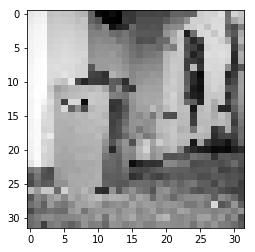

['AA', 'B', 'EH', 'IY', 'K', 'N', 'R', 'S', 'S', 'T']


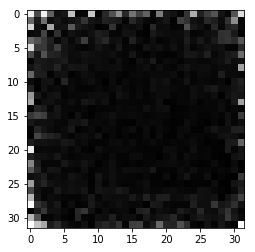

8600 1083.1986 15.241045 1052.7166 15.241045


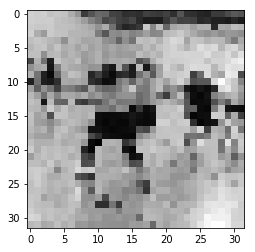

['AA', 'AO', 'B', 'IY', 'L', 'L', 'V']


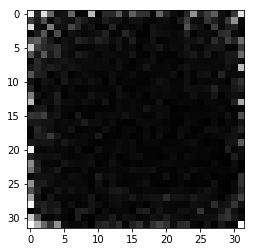

8800 992.61865 14.921306 962.77606 14.921306


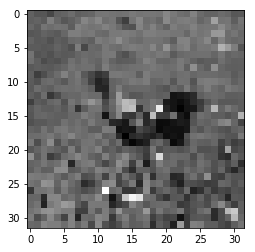

['AA', 'AH', 'G', 'IY', 'L', 'N']


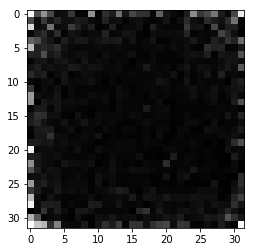

9000 1019.9199 14.774105 990.3717 14.774105


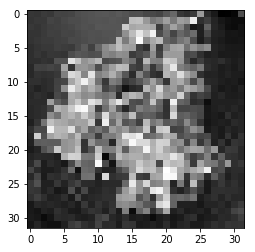

['AA', 'AH', 'B', 'IY', 'N', 'P', 'R', 'T']


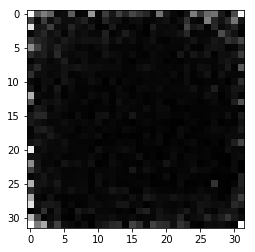

9200 1015.81854 15.414378 984.9898 15.414378


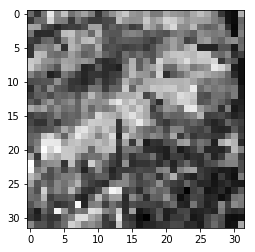

['AA', 'AE', 'IY', 'K', 'M', 'N']


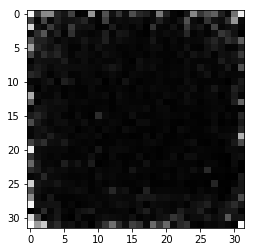

9400 1049.7285 15.222704 1019.283 15.222704


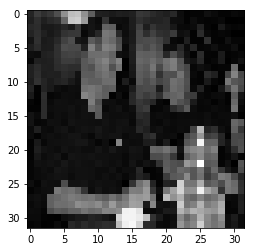

['AH', 'AO', 'ER', 'G', 'JH', 'T', 'W']


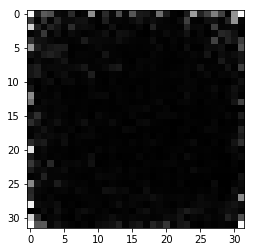

9600 1053.2615 14.770664 1023.7201 14.770664


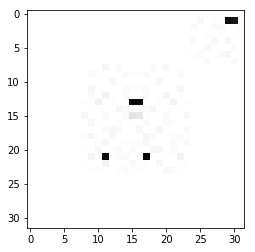

['AY', 'IH', 'L', 'NG', 'P', 'S', 'S']


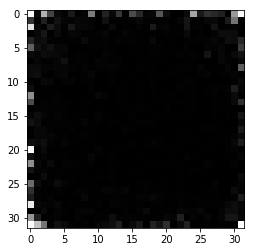

9800 1057.6638 15.571946 1026.52 15.571946


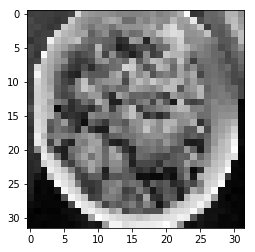

['AE', 'ER', 'IY', 'K', 'L', 'M']


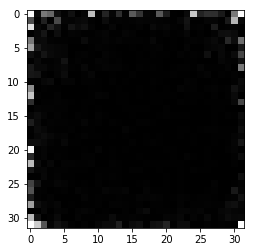

10000 1000.44116 15.212209 970.0167 15.212209


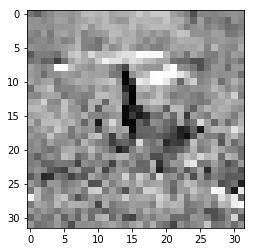

['AW', 'EH', 'F', 'IY', 'L', 'P', 'R', 'R']


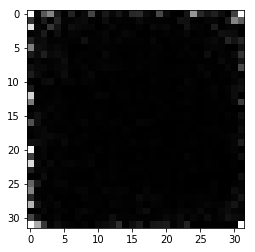

10200 1104.501 16.179867 1072.1412 16.179867


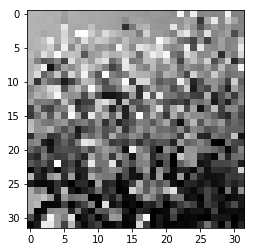

['AA', 'AH', 'D', 'IY', 'M', 'N', 'R', 'T']


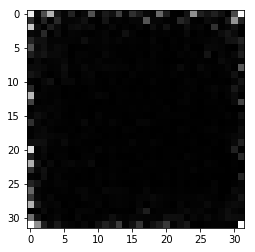

10400 1043.3027 13.658064 1015.9866 13.658064


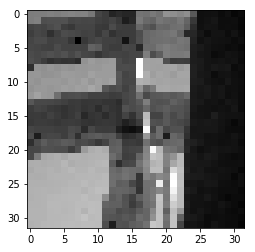

['JH', 'OY', 'S', 'T']


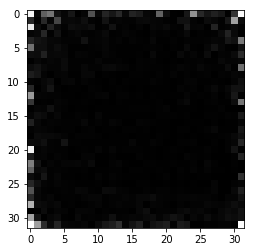

10600 1045.7552 14.33485 1017.0856 14.33485


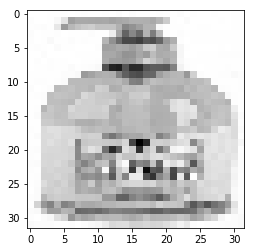

['AA', 'AH', 'B', 'D', 'IY', 'L', 'N', 'OW', 'SH']


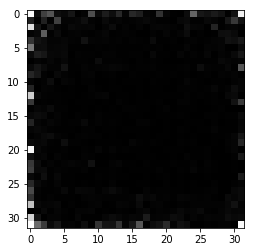

10800 1068.8214 15.611126 1037.5991 15.611126


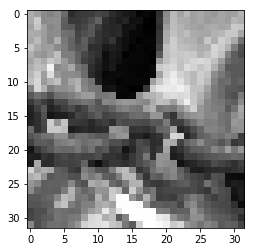

['CH', 'EY', 'N', 'N', 'OW', 'S']


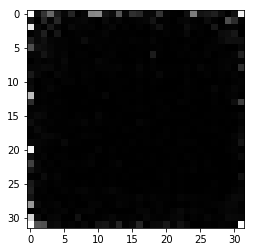

11000 1043.5522 13.804071 1015.9441 13.804071


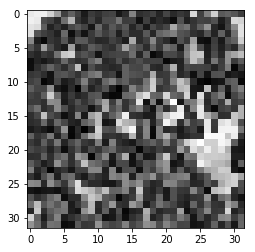

['AH', 'AH', 'B', 'EH', 'HH', 'IY', 'K', 'L', 'R']


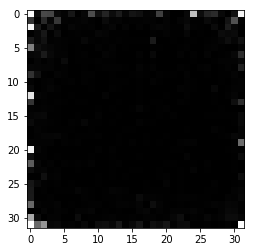

11200 1027.9844 15.794104 996.39606 15.794104


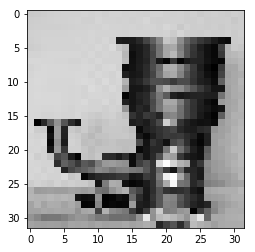

['AH', 'AH', 'D', 'F', 'IH', 'M', 'N', 'P', 'P', 'UW', 'Y', 'ZH']


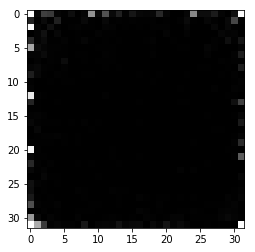

11400 1085.9508 14.909501 1056.1318 14.909501


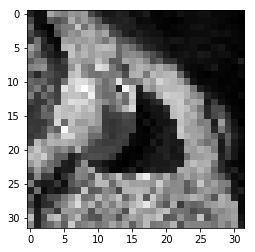

['AE', 'ER', 'IY', 'JH', 'N', 'N', 'T']


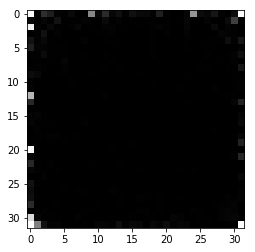

11600 1002.1883 14.389698 973.4089 14.389698


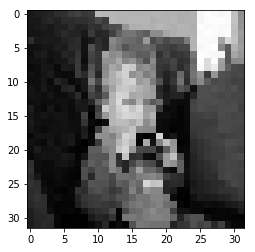

['AH', 'EH', 'ER', 'K', 'L', 'N', 'V', 'Z']


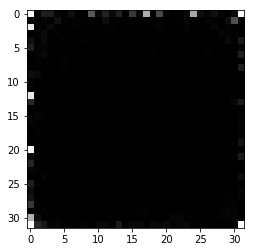

11800 1018.5765 14.828981 988.9185 14.828981


In [23]:
imagenet = ImageNet(batch_size)

for i in range(imagenet.N * 3):
    batch, p_batch = imagenet.next_batch()
    sess.run(optimizer, feed_dict = {X_in: batch, p_in: p_batch, Y: batch, keep_prob: 0.8})
        
    if not i % 200:
        ls, d, i_ls, d_ls, l_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, label_loss, mean, sd], feed_dict = {X_in: batch, p_in: p_batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [32, 32]), cmap='gray')
        plt.show()
        print(phone_vec2bag(p_batch[0]))
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(l_ls), np.mean(d_ls))

['B', 'EH', 'R']


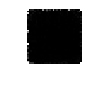

['AO', 'EH', 'Y']


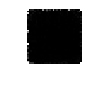

['K', 'M', 'V']


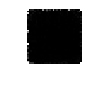

['AE', 'AH', 'DH']


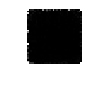

['B', 'JH', 'TH']


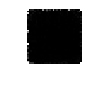

['AO', 'P', 'V']


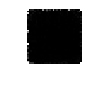

['AA', 'K', 'NG']


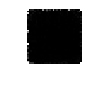

['AE', 'K', 'T']


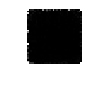

['AA', 'ER', 'P']


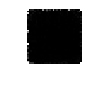

['L', 'P', 'TH']


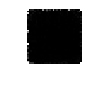

['JH', 'Y', 'Z']


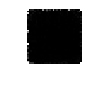

['AH', 'JH', 'UW']


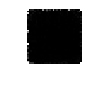

['N', 'OY', 'SH']


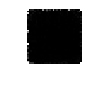

['AA', 'HH', 'TH']


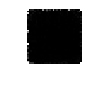

['N', 'OY', 'UH']


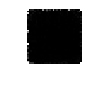

['DH', 'L', 'SH']


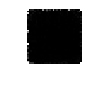

['NSN', 'AH', 'P']


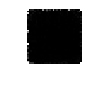

['G', 'N', 'Y']


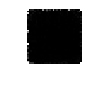

['EH', 'G', 'T']


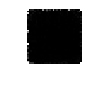

['AH', 'B', 'K']


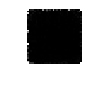

In [24]:
def rand_phones():
    vec = np.zeros(p_N)
    rands = np.random.randint(0, p_N, 3)
    for r in rands:
        vec[r] += 1
    return vec

randoms = [np.random.normal(0, 1, n_latent) for _ in range(20)]
p_rand = [rand_phones() for _ in range(20)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, p_in: p_rand, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [32, 32]) for i in range(len(imgs))]

for i, img in enumerate(imgs):
    print(phone_vec2bag(p_rand[i]))
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()